In [1]:
%matplotlib inline

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import itertools
import rasterio
from rasterio.warp import transform
import affine
from rasterio.merge import merge
from rasterio.plot import show
import matplotlib.image as mpimg


In [2]:
def find_file(category, num_times, img, date, pixels, input_source):
    
    filter_sentence = r'^' + '.*t_' + str(num_times) + '.*.nc$'
    products_list = list(filter(re.compile(filter_sentence).search, os.listdir(os.path.join(input_source,category))))

    for i, product in enumerate(products_list):
        pos = product.index('pxl_')
        posend = product.index('_t')
        pixelnumber = int(product[pos+4:posend])
        if pixelnumber < pixels:
            products_list.remove(products_list[i])
    data_xa = [xr.open_dataset(os.path.join(input_source,category,product)) for product in products_list]

    for i, product in enumerate(products_list):
        data_xa[i].attrs['name_region'] = product
        
    return data_xa[img].isel(time = date).drop('time')

## Select images to read

In [3]:
images_cod = pd.read_csv("data/images_classificated.csv")
pixels = 1500
categories = ["low","middle","high"] 

categorieslist = []

for category in categories:
    sub_data = images_cod[images_cod.category == category]

    for i in range(sub_data.shape[0]):
        xa_data = find_file(category=category,num_times= sub_data.dates_wrapped.get_values()[i], img= sub_data.num_field.get_values()[i], date=sub_data.date.get_values()[i],  pixels=pixels, input_source="data/")
        print(xa_data.attrs['name_region'])
        categorieslist.append(xa_data)


t_2_pxl_3120_tol_guam_esquinero_esquinero_2016.nc
t_2_pxl_3120_tol_guam_esquinero_esquinero_2016.nc
t_2_pxl_3150_tol_guam_quita sueño_roncalar 2_2017.nc
t_2_pxl_780_tol_amba_santuario_boba a _2016.nc
t_2_pxl_2925_tol_guam_san carlos _san carlos _2017.nc
t_2_pxl_780_tol_amba_santuario_boba a _2016.nc
t_3_pxl_1650_tol_alva_buaria_bais 2 b_2017.nc
t_2_pxl_104_tol_leri_villa ortiz_mango_2016.nc
t_2_pxl_110_tol_sald__7500 mts_2017.nc
t_2_pxl_120_tol_puri__el coco_2016.nc
t_2_pxl_120_tol_puri__el coco_2016.nc
t_2_pxl_130_tol_puri__el monte_2016.nc
t_2_pxl_144_tol_sald_las malbinas__2017.nc
t_2_pxl_160_tol_sald_parcela 16_parcela 16_2016.nc
t_2_pxl_160_tol_sald_parcela 16_parcela 16_2016.nc
t_2_pxl_1804_tol_espi_esparta_esparta_2016.nc
t_2_pxl_272_tol_sald_el porvenir__2016.nc
t_2_pxl_4087_tol_espi_esparta_esparta_2016.nc
t_2_pxl_828_tol_ibag_piamonte_4b_2016.nc
t_2_pxl_1804_tol_sald__mango 1_2017.nc
t_2_pxl_65_tol_sald_el cauca_el cauca_2017.nc
t_2_pxl_868_tol_arme_parcela 30_lote 1_2017.nc


## Unsupervised Classification

In [4]:
features = ['blue', 'green', 'red', 'nir', 'vre_1', 'vre_2', 'vre_3', 'swir1', 'swir2', 'narrow_nir']

In [5]:
datatomerge = [categorieslist[i][features[0]].data.ravel().tolist() for i in range(len(categorieslist))]
data_band = list(itertools.chain(*datatomerge))

data_bands = pd.DataFrame({features[0] : data_band})

for feature in features:
    datatomerge = [categorieslist[i][feature].data.ravel().tolist() for i in range(len(categorieslist))]
    data_band = list(itertools.chain(*datatomerge))
    data_bands[feature] = data_band

print(data_bands.shape)
print(data_bands.head())

(27433, 10)
   blue  green  red  nir  vre_1  vre_2  vre_3  swir1  swir2  narrow_nir
0   NaN    NaN  NaN  NaN    NaN    NaN    NaN    NaN    NaN         NaN
1   NaN    NaN  NaN  NaN    NaN    NaN    NaN    NaN    NaN         NaN
2   NaN    NaN  NaN  NaN    NaN    NaN    NaN    NaN    NaN         NaN
3   NaN    NaN  NaN  NaN    NaN    NaN    NaN    NaN    NaN         NaN
4   NaN    NaN  NaN  NaN    NaN    NaN    NaN    NaN    NaN         NaN


### get numpy data for robust scalar 

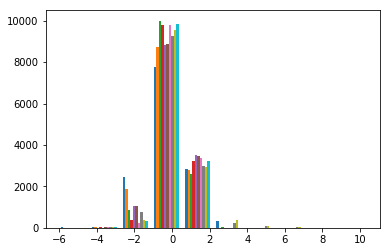

In [6]:
from sklearn.preprocessing import RobustScaler

data_bands_without_na = data_bands[np.logical_not(pd.isnull(data_bands).any(axis=1))]

#data_bands_without_na.hist()

scaled_data = RobustScaler(quantile_range=(25, 75)).fit_transform(data_bands_without_na)
plt.hist(scaled_data)
plt.show()


### calculate PCA

In [7]:
from sklearn.decomposition import PCA

pcamodel= PCA(.9)

principalComponents = pcamodel.fit_transform(scaled_data)
principalComponents = pd.DataFrame(data = principalComponents, columns= ['pc1', 'pc2', 'pc3'])
principalComponents.shape
principalComponents.head()

,pc1,pc2,pc3
0,-3.954707,0.124771,0.949286
1,-4.242384,0.467728,1.781461
2,-4.183495,0.565784,1.773854
3,-3.828865,-0.611561,0.706608
4,-3.208669,0.030106,1.047952


### unsupervised Classification: k-means


243
   target
0     NaN
1     NaN
2     NaN
3     NaN
4     NaN


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000017CDC06D208>]],
      dtype=object)

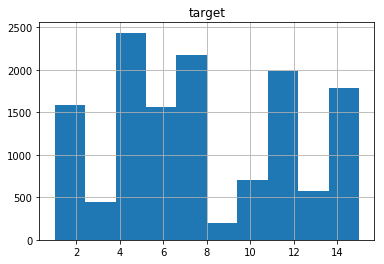

In [8]:
from sklearn.cluster import KMeans
numClust = 15
kmeans = KMeans(n_clusters=numClust, random_state=0).fit(principalComponents)

len(kmeans.labels_)
flat_list = np.full(data_bands.shape[0], -1)

data_target = pd.DataFrame({'target' : flat_list})
print(kmeans.labels_.ravel().tolist().count(0))
data_target.loc[data_bands_without_na.index, 'target'] = kmeans.labels_

data_target[data_target.target==0] = numClust
data_target[data_target.target==-1] = None
print(data_target.head())
data_target.hist()

### Export classified images

C:\Users\JANUS\AppData\Local\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


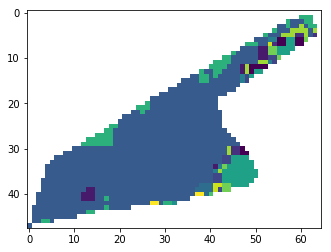

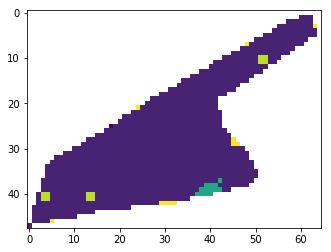

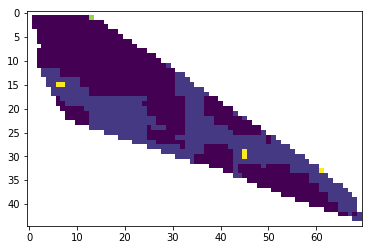

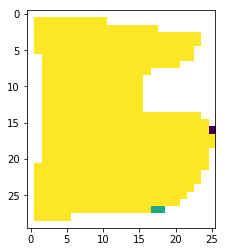

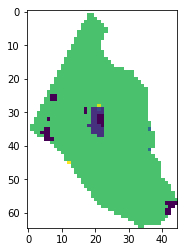

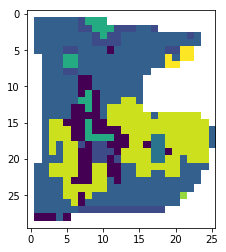

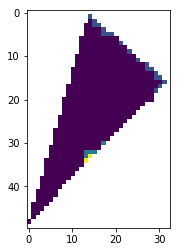

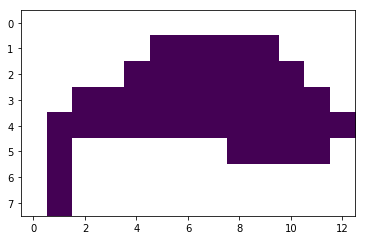

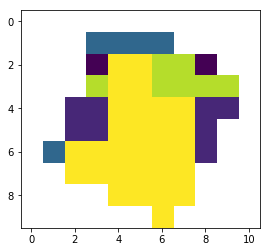

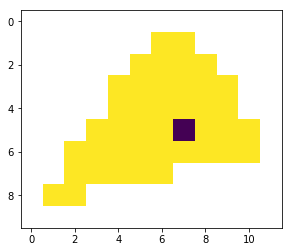

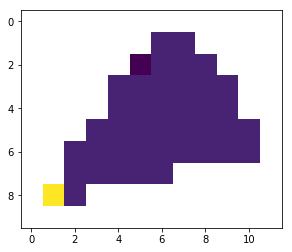

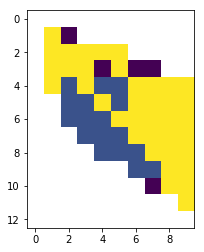

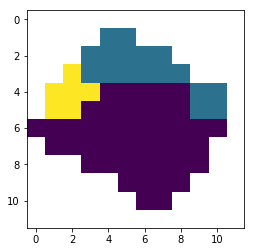

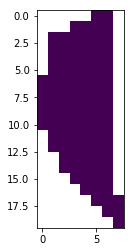

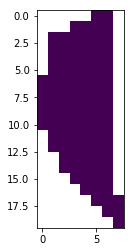

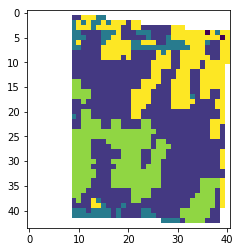

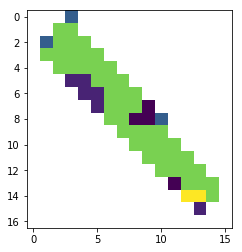

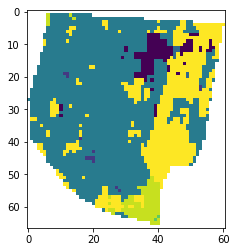

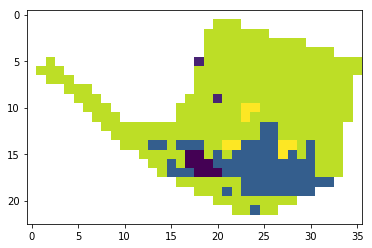

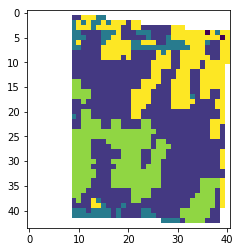

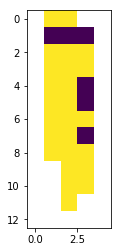

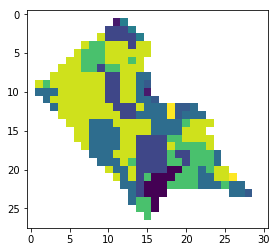

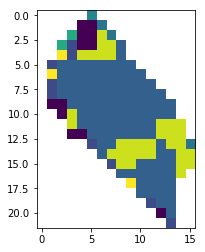

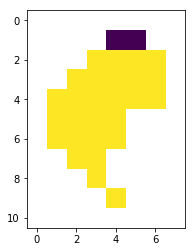

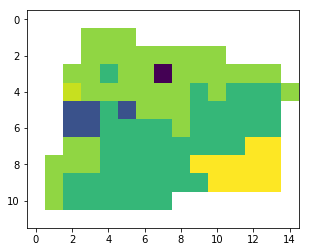

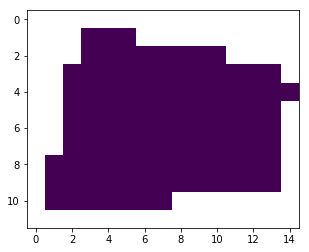

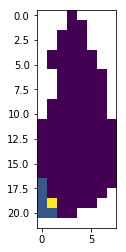

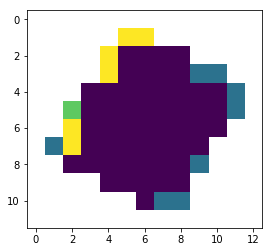

In [9]:

longeach = [len(img_xa.x.values) * len(img_xa.y.values) for img_xa in categorieslist]
for i in range(len(categorieslist)):
    xtest = categorieslist[i]
    
    dim_array = xtest.x.values.shape[0] * xtest.y.values.shape[0]
    if i >0:
        dataExport = data_target.loc[range(np.sum(longeach[:i]), np.sum(longeach[:i+1])), 'target'].values.reshape(xtest.coords.dims['y'],xtest.coords.dims['x'])
    else:
        dataExport = data_target.loc[range(0, np.sum(longeach[:i+1])), 'target'].values.reshape(xtest.coords.dims['y'],xtest.coords.dims['x'])
    plt.figure()
    plt.imshow(dataExport)

    ## create affin transformation matrix
    crs_ = categorieslist[0].attrs['crs']
    trans_data = xtest.attrs['tran']
    transAff = affine.Affine(trans_data[1],trans_data[2],trans_data[0],
        trans_data[4], trans_data[5], trans_data[3])    
    
    ## export tiff
    profile = {'transform': transAff,'driver': 'GTiff','crs': crs_[crs_.index("epsg:"):], 'height': dataExport.shape[0], 'width': dataExport.shape[1], 'count': 1, 'dtype': rasterio.uint8}
    with rasterio.open('output/kmeans/'+ images_cod['category'][i] + '_img_'+str(i)+'.tif', 'w', **profile) as dst:
        dst.write(dataExport.reshape(1,dataExport.shape[0], dataExport.shape[1]).astype(rasterio.uint8))
        dst.close()
    

### create a mosaic image

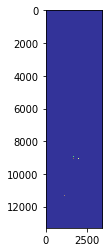

In [10]:
listimgs= []
for i in range(len(categorieslist)):
    raster_test = rasterio.open('output/kmeans/'+ images_cod['category'][i] + '_img_'+str(i)+'.tif')
    listimgs.append(raster_test)

mosaic, out_trans = merge(listimgs)
show(mosaic, cmap='terrain') 
out_meta = raster_test.meta.copy()

# Update the metadata
out_meta.update({"driver": "GTiff", "height": mosaic.shape[1], "width": mosaic.shape[2], "transform": out_trans} )

with rasterio.open('output/kmeans/mosaic_image_pca_robust'+str(numClust)+'.tif', 'w', **out_meta) as dst:
        dst.write(mosaic)